In [1]:
# Try to find out why CNN has the best accuracy in predicting ages

# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [137]:
# Apply PCA

from sklearn.decomposition import PCA

pca = PCA(80)
pca.fit(np.vstack([subj.T for subj in train_rest_ts]))

train_rest_ts_pca = [pca.transform(subj.T).T for subj in train_rest_ts]
test_rest_ts_pca = [pca.transform(subj.T).T for subj in test_rest_ts]

print('Complete')

Complete


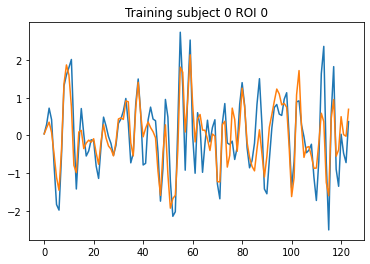

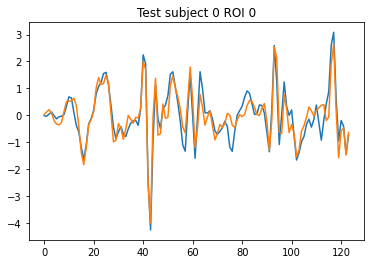

In [138]:
# Test PCA

import matplotlib.pyplot as plt

reconTrain = pca.inverse_transform(train_rest_ts_pca[0].T).T
reconTest = pca.inverse_transform(test_rest_ts_pca[0].T).T

plt.plot(train_rest_ts[0][0,:])
plt.plot(reconTrain[0,:])
plt.title('Training subject 0 ROI 0')
plt.show()

plt.plot(test_rest_ts[0][0,:])
plt.plot(reconTest[0,:])
plt.title('Test subject 0 ROI 0')
plt.show()

In [5]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in test_rest_ts]

print(train_rest_ts_torch[0].device)
print(train_rest_ts_torch[0].shape)
print('Complete')

cuda:0
torch.Size([231, 264])
Complete


In [223]:
# Most successful model

import math

nt = train_rest_ts_torch[0].shape[0]
nc = 10
nrois = train_rest_ts_torch[0].shape[1]

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
#         self.cl1 = nn.Conv2d(1,nc,(5,nrois)).cuda() # Output size 10x1x(nt-4)
#         self.cl2 = nn.Conv2d(1,nc,(9,nrois)).cuda() # Output size 10x1x(nt-8)
        self.cl3 = nn.Conv2d(1,nc,(13,nrois)).cuda() # Output size 10x1x(nt-12)
        self.mp1 = nn.MaxPool1d(10,5).cuda() # nc*math.floor((nt-4-10)/5+1)...
        self.fc1 = nn.Linear(nc*(0*math.floor((nt-4-10)/5+1)+0*math.floor((nt-8-10)/5+1)+math.floor((nt-12-10)/5+1)), 1).cuda()
    
    def forward(self, x):
        nb = x.shape[0]
#         y1 = F.relu(self.cl1(x))
#         y1 = y1.reshape(nb,nc,nt-4)
#         y1 = self.mp1(y1)
#         y2 = F.relu(self.cl2(x))
#         y2 = y2.reshape(nb,nc,nt-8)
#         y2 = self.mp1(y2)
        y3 = F.relu(self.cl3(x))
        y3 = y3.reshape(nb,nc,nt-12)
        y3 = self.mp1(y3)
        y = torch.cat([y3],dim=2)
        y = y.reshape(nb,-1)
        y = self.fc1(y)
        return y
    
cnn = CNN()
optim = torch.optim.Adam(cnn.parameters(), lr=2e-3)

print('Complete')

Complete


In [224]:
import random

N = len(train_rest_ts_torch)-1
running = 0
nEpoch = 1000
pPeriod = 100
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_ts_torch[idx]
        batch.append(subj.unsqueeze(0).unsqueeze(0))
        truth[i] = y_train[idx,0]
    optim.zero_grad()
    pred = cnn(torch.cat(batch)).view(nBatch)
    loss = torch.sum((truth.cuda()-pred)**2)
    loss.backward()
    optim.step()
    running += loss.cpu()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=303610.250000
epoch 100 loss=53913.148438
epoch 200 loss=9646.402344
epoch 300 loss=6103.908203
epoch 400 loss=3499.502441
epoch 500 loss=1764.305054
epoch 600 loss=1020.656006
epoch 700 loss=494.086090
epoch 800 loss=179.240982
epoch 900 loss=77.727715
epoch 999 loss=24.359678
Finished training


[[1.         0.65042221]
 [0.65042221 1.        ]]
2.3026199902878894
1.8656382519974668


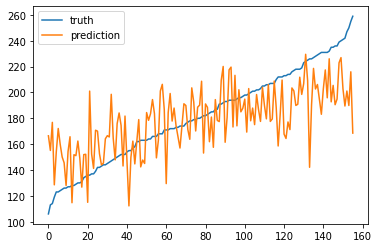

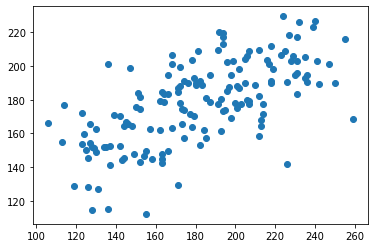

In [225]:
# Get predictions

import matplotlib.pyplot as plt

y = y_test
X = test_rest_ts_torch
N = len(y)

# pred = np.zeros(N)
# y1 = np.zeros(N) # rmse
# y2 = np.zeros(N) # mae
# for i in range(N):
#     pred[i] = cnn(X[i].unsqueeze(0).unsqueeze(0))[0]
#     y1[i] = (y[i,0]-pred[i])**2
#     y2[i] = abs(y[i,0]-pred[i])

batch = []
for i in range(N):
    batch.append(X[i].unsqueeze(0).unsqueeze(0).cuda())

batch = torch.cat(batch)
pred = cnn(batch).view(N).cpu().detach().numpy()
y1 = (y.reshape(N)-pred)**2 # rmse
y2 = abs(y.reshape(N)-pred) # mae
    
print(np.corrcoef(y.flatten(), pred))
print((y1.sum()/N)**0.5/12)
print(y2.sum()/N/12)
# print(y1)
# print(y2)

idcs = np.argsort(y,axis=0)
plt.plot(y[idcs,0], label='truth')
plt.plot(pred[idcs], label='prediction')
plt.legend()
plt.show()

plt.scatter(y.flatten(), pred)
plt.show()

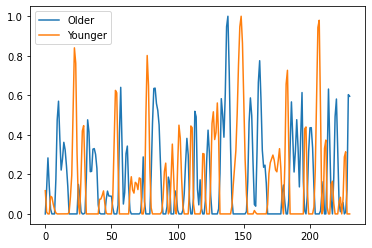

Older sum: 39.729378
Younger sum: 34.368343
Age in years: 15.166667
Predicted age: 15.926757
Top 5 older: [138 137 162 139 161]
Top 5 younger: [148 207 147 206 149]


In [226]:
# Try to do grad-CAM on regression
# First see which signals contribute most to advanced age prediction

from pytorch_grad_cam import GradCAM

target_category = 0
X = test_rest_ts_torch
y = y_test
subId = 0

# Positive

cam = GradCAM(cnn, cnn.cl3, use_cuda=True)
grayCamPos = cam(input_tensor=X[subId].unsqueeze(0).unsqueeze(0).cuda(), target_category=target_category)

# Negative

cam = GradCAM(cnn, cnn.cl3, use_cuda=True, negative=True)
grayCamNeg = cam(input_tensor=X[subId].unsqueeze(0).unsqueeze(0).cuda(), target_category=target_category)

plt.plot(grayCamPos[0,:,0], label='Older')
plt.plot(grayCamNeg[0,:,0], label='Younger')
plt.legend()
plt.show()

print('Older sum: {:f}'.format(np.sum(grayCamPos[0,:,0])))
print('Younger sum: {:f}'.format(np.sum(grayCamNeg[0,:,0])))
print('Age in years: {:f}'.format(y[subId,0]/12))
print('Predicted age: {:f}'.format(-cam.loss/12))
print('Top 5 older: ' + str(np.argsort(-grayCamPos[0,:,0])[0:5]))
print('Top 5 younger: ' + str(np.argsort(-grayCamNeg[0,:,0])[0:5]))

In [91]:
# grad-CAM loss function not suited to RMSE loss...
# Try a homecooked approach based on the grad-CAM code

inp = train_rest_ts_torch[0].unsqueeze(0).unsqueeze(0).cuda()
cnn.zero_grad()
age = cnn(inp).view(1).cpu()
age.backward()
print(cnn.fc2.weight.grad)
print(cnn.fc1.weight.grad)

tensor([[ 0.0000, 36.5542,  0.0000, 35.8302, 31.0382, 41.2708, 34.4396, 42.3147,
          0.0000, 33.7951,  0.0000, 27.4096, 31.5425,  0.0000, 38.9915,  0.0000,
         40.6729, 42.0828, 39.7176,  0.0000,  0.0000,  0.0000, 36.5312, 39.6069,
         39.5939, 38.2326,  0.0000, 41.3681, 39.0705, 41.1525, 31.9642,  0.0000,
          0.0000,  0.0000,  0.0000, 42.0625, 40.9235,  0.0000,  0.0000,  0.0000,
          0.0000, 38.3209,  0.0000,  0.0000, 38.3566, 41.1821, 41.7652, 39.8519,
         37.0180,  0.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0124, 0.0170],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0162, 0.0223],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0198, 0.0272],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [130]:
# Test gradients

x = torch.tensor([[1],[0]], dtype=float, requires_grad=True)
l1 = torch.tensor([[1,2],[3,4]], dtype=float, requires_grad=True)
l2 = torch.tensor([[1,1],[1,1]], dtype=float, requires_grad=True)
l3 = torch.tensor([[10,1],[2,2]], dtype=float, requires_grad=True)
l4 = torch.tensor([[1,1]], dtype=float, requires_grad=True)
a = l1@x
b = l2@a
c = l3@b
y = l4@c
y.backward()
print(y)
print(c)
print(b)
print(a)
print(l4.grad)
print(l3.grad)
print(l2.grad)
print(l1.grad)

tensor([[60.]], dtype=torch.float64, grad_fn=<MmBackward>)
tensor([[44.],
        [16.]], dtype=torch.float64, grad_fn=<MmBackward>)
tensor([[4.],
        [4.]], dtype=torch.float64, grad_fn=<MmBackward>)
tensor([[1.],
        [3.]], dtype=torch.float64, grad_fn=<MmBackward>)
tensor([[44., 16.]], dtype=torch.float64)
tensor([[4., 4.],
        [4., 4.]], dtype=torch.float64)
tensor([[12., 36.],
        [ 3.,  9.]], dtype=torch.float64)
tensor([[15.,  0.],
        [15.,  0.]], dtype=torch.float64)


torch.Size([10, 1, 5, 264])


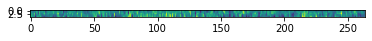

In [74]:
# Examine the weights of the temporal convolution kernels

w = cnn.cl1.weight
print(w.shape)

for c in range(w.shape[0]):
    plt.imshow(w[c,0,:,:].detach().numpy())
    plt.show()